In [1]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [2]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 0 with the lowest memory usage.


In [3]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [4]:
spot_size=50
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.9
dataset_name="hBreast"
kmeans_init=True
custom_init="Leiden"
spatial_init=True
num_clusters=7
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00

In [5]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [6]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [7]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=False, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=False, K=K)[1.0]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [30,0,0], thread: [96,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [25,0,0], thread: [3,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [30,0,0], thread: [9,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [33,0,0], thread: [96,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [33,0,0], thread: [102,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [33,0,0], thread: [106,0,0] Assertion `-size

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


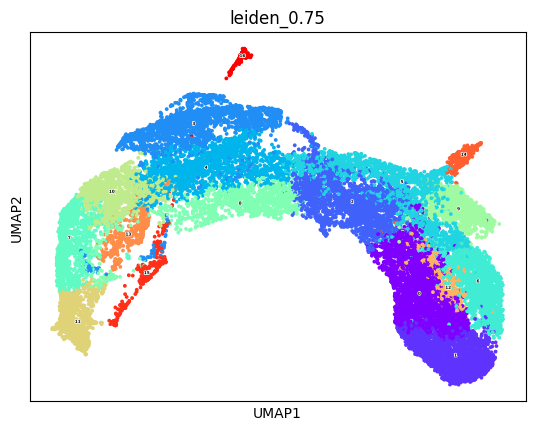

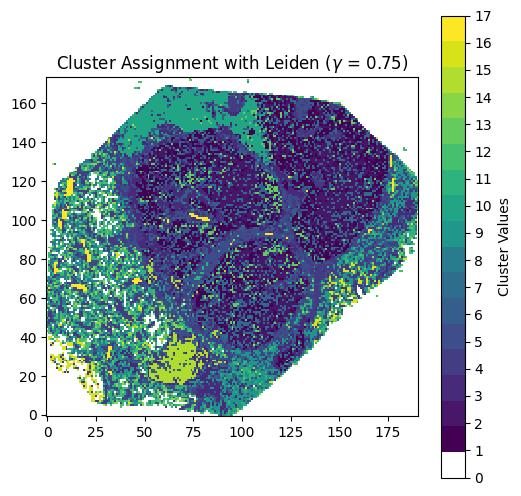

In [8]:
# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 1000

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/mpd.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [34]:
# grab the mpd distance of cluster labels
mpd = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(mpd.values()) / 1_000_000

0.025251812393883227

In [35]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [36]:
learn_global_variances = True

In [37]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [38]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([7, 3]), torch.Size([7, 3]))

In [39]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [40]:
pyro.clear_param_store()
NUM_EPOCHS = 1000
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.005, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 10
patience_counter = 0
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        # print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])


        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 1:   0%|          | 1/1000 [00:00<15:08,  1.10it/s]

Epoch 0 : loss = 12364.4626


Epoch 2:   0%|          | 2/1000 [00:01<15:12,  1.09it/s]

Epoch 1 : loss = 11810.7839


Epoch 3:   0%|          | 3/1000 [00:02<15:12,  1.09it/s]

Epoch 2 : loss = 11389.3441


Epoch 4:   0%|          | 4/1000 [00:03<15:06,  1.10it/s]

Epoch 3 : loss = 11037.0615


Epoch 5:   0%|          | 5/1000 [00:04<14:37,  1.13it/s]

Epoch 4 : loss = 10786.6285


Epoch 6:   1%|          | 6/1000 [00:05<14:32,  1.14it/s]

Epoch 5 : loss = 10565.8439


Epoch 7:   1%|          | 7/1000 [00:06<14:38,  1.13it/s]

Epoch 6 : loss = 10371.6993


Epoch 8:   1%|          | 8/1000 [00:07<14:47,  1.12it/s]

Epoch 7 : loss = 10262.1629


Epoch 9:   1%|          | 9/1000 [00:08<14:52,  1.11it/s]

Epoch 8 : loss = 10150.2265


Epoch 10:   1%|          | 10/1000 [00:08<14:56,  1.10it/s]

Epoch 9 : loss = 10033.8543


Epoch 11:   1%|          | 11/1000 [00:09<14:58,  1.10it/s]

Epoch 10 : loss = 9967.0502


Epoch 12:   1%|          | 12/1000 [00:10<14:59,  1.10it/s]

Epoch 11 : loss = 9903.3221


Epoch 13:   1%|▏         | 13/1000 [00:11<14:59,  1.10it/s]

Epoch 12 : loss = 9832.2768


Epoch 14:   1%|▏         | 14/1000 [00:12<15:00,  1.10it/s]

Epoch 13 : loss = 9769.6097


Epoch 15:   2%|▏         | 15/1000 [00:13<14:59,  1.09it/s]

Epoch 14 : loss = 9720.6511


Epoch 16:   2%|▏         | 16/1000 [00:14<14:58,  1.10it/s]

Epoch 15 : loss = 9685.1391


Epoch 17:   2%|▏         | 17/1000 [00:15<14:59,  1.09it/s]

Epoch 16 : loss = 9632.0761


Epoch 18:   2%|▏         | 18/1000 [00:16<15:03,  1.09it/s]

Epoch 17 : loss = 9605.661


Epoch 19:   2%|▏         | 19/1000 [00:17<15:01,  1.09it/s]

Epoch 18 : loss = 9567.8477


Epoch 20:   2%|▏         | 20/1000 [00:18<14:58,  1.09it/s]

Epoch 19 : loss = 9521.4993


Epoch 21:   2%|▏         | 21/1000 [00:19<14:56,  1.09it/s]

Epoch 20 : loss = 9499.9111


Epoch 22:   2%|▏         | 22/1000 [00:19<14:55,  1.09it/s]

Epoch 21 : loss = 9480.6849


Epoch 23:   2%|▏         | 23/1000 [00:20<14:56,  1.09it/s]

Epoch 22 : loss = 9459.4983


Epoch 24:   2%|▏         | 24/1000 [00:21<14:54,  1.09it/s]

Epoch 23 : loss = 9404.2007


Epoch 25:   2%|▎         | 25/1000 [00:22<14:50,  1.09it/s]

Epoch 24 : loss = 9388.1374


Epoch 26:   3%|▎         | 26/1000 [00:23<14:47,  1.10it/s]

Epoch 25 : loss = 9388.562


Epoch 27:   3%|▎         | 27/1000 [00:24<14:47,  1.10it/s]

Epoch 26 : loss = 9354.8404


Epoch 28:   3%|▎         | 28/1000 [00:25<14:47,  1.10it/s]

Epoch 27 : loss = 9323.4991


Epoch 29:   3%|▎         | 29/1000 [00:26<14:46,  1.09it/s]

Epoch 28 : loss = 9309.5025


Epoch 30:   3%|▎         | 30/1000 [00:27<14:46,  1.09it/s]

Epoch 29 : loss = 9293.698


Epoch 31:   3%|▎         | 31/1000 [00:28<14:45,  1.09it/s]

Epoch 30 : loss = 9289.9289


Epoch 32:   3%|▎         | 32/1000 [00:29<14:45,  1.09it/s]

Epoch 31 : loss = 9241.7726


Epoch 33:   3%|▎         | 33/1000 [00:30<14:44,  1.09it/s]

Epoch 32 : loss = 9247.8596


Epoch 34:   3%|▎         | 34/1000 [00:30<14:21,  1.12it/s]

Epoch 33 : loss = 9230.5916


Epoch 35:   4%|▎         | 35/1000 [00:31<14:21,  1.12it/s]

Epoch 34 : loss = 9221.8937


Epoch 36:   4%|▎         | 36/1000 [00:32<14:26,  1.11it/s]

Epoch 35 : loss = 9201.9665


Epoch 37:   4%|▎         | 37/1000 [00:33<14:28,  1.11it/s]

Epoch 36 : loss = 9190.0699


Epoch 38:   4%|▍         | 38/1000 [00:34<14:31,  1.10it/s]

Epoch 37 : loss = 9185.2545


Epoch 39:   4%|▍         | 39/1000 [00:35<14:32,  1.10it/s]

Epoch 38 : loss = 9155.0901


Epoch 40:   4%|▍         | 40/1000 [00:36<14:33,  1.10it/s]

Epoch 39 : loss = 9165.5776


Epoch 41:   4%|▍         | 41/1000 [00:37<14:34,  1.10it/s]

Epoch 40 : loss = 9142.7049


Epoch 42:   4%|▍         | 42/1000 [00:38<14:31,  1.10it/s]

Epoch 41 : loss = 9123.726


Epoch 43:   4%|▍         | 43/1000 [00:39<14:32,  1.10it/s]

Epoch 42 : loss = 9112.9924


Epoch 44:   4%|▍         | 44/1000 [00:39<14:31,  1.10it/s]

Epoch 43 : loss = 9097.2668


Epoch 45:   4%|▍         | 45/1000 [00:40<14:31,  1.10it/s]

Epoch 44 : loss = 9094.4523


Epoch 46:   5%|▍         | 46/1000 [00:41<14:30,  1.10it/s]

Epoch 45 : loss = 9084.5693


Epoch 47:   5%|▍         | 47/1000 [00:42<14:26,  1.10it/s]

Epoch 46 : loss = 9097.9318


Epoch 48:   5%|▍         | 48/1000 [00:43<14:26,  1.10it/s]

Epoch 47 : loss = 9099.9257


Epoch 49:   5%|▍         | 49/1000 [00:44<14:26,  1.10it/s]

Epoch 48 : loss = 9077.2479


Epoch 50:   5%|▌         | 50/1000 [00:45<14:26,  1.10it/s]

Epoch 49 : loss = 9056.3928


Epoch 51:   5%|▌         | 51/1000 [00:46<14:24,  1.10it/s]

Epoch 50 : loss = 9061.9669


Epoch 52:   5%|▌         | 52/1000 [00:47<14:24,  1.10it/s]

Epoch 51 : loss = 9040.8074


Epoch 53:   5%|▌         | 53/1000 [00:48<14:24,  1.10it/s]

Epoch 52 : loss = 9054.6312


Epoch 54:   5%|▌         | 54/1000 [00:49<14:23,  1.10it/s]

Epoch 53 : loss = 9054.5019


Epoch 55:   6%|▌         | 55/1000 [00:50<14:22,  1.10it/s]

Epoch 54 : loss = 9018.5726


Epoch 56:   6%|▌         | 56/1000 [00:50<14:22,  1.09it/s]

Epoch 55 : loss = 9019.4351


Epoch 57:   6%|▌         | 57/1000 [00:51<14:18,  1.10it/s]

Epoch 56 : loss = 9014.2366


Epoch 58:   6%|▌         | 58/1000 [00:52<14:13,  1.10it/s]

Epoch 57 : loss = 8993.9325


Epoch 59:   6%|▌         | 59/1000 [00:53<14:25,  1.09it/s]

Epoch 58 : loss = 8990.0461


Epoch 60:   6%|▌         | 60/1000 [00:54<15:19,  1.02it/s]

Epoch 59 : loss = 9002.0598


Epoch 61:   6%|▌         | 61/1000 [00:55<16:04,  1.03s/it]

Epoch 60 : loss = 8977.8221


Epoch 62:   6%|▌         | 62/1000 [00:57<16:36,  1.06s/it]

Epoch 61 : loss = 8976.8031


Epoch 63:   6%|▋         | 63/1000 [00:58<16:57,  1.09s/it]

Epoch 62 : loss = 8988.4891


Epoch 64:   6%|▋         | 64/1000 [00:59<17:06,  1.10s/it]

Epoch 63 : loss = 8982.1224


Epoch 65:   6%|▋         | 65/1000 [01:00<17:10,  1.10s/it]

Epoch 64 : loss = 8968.6929


Epoch 66:   7%|▋         | 66/1000 [01:01<17:20,  1.11s/it]

Epoch 65 : loss = 8980.2671


Epoch 67:   7%|▋         | 67/1000 [01:02<17:26,  1.12s/it]

Epoch 66 : loss = 8953.4227


Epoch 68:   7%|▋         | 68/1000 [01:03<17:25,  1.12s/it]

Epoch 67 : loss = 8947.2207


Epoch 69:   7%|▋         | 69/1000 [01:05<17:30,  1.13s/it]

Epoch 68 : loss = 8957.082


Epoch 70:   7%|▋         | 70/1000 [01:06<17:28,  1.13s/it]

Epoch 69 : loss = 8948.091


Epoch 71:   7%|▋         | 71/1000 [01:07<17:24,  1.12s/it]

Epoch 70 : loss = 8931.9204


Epoch 72:   7%|▋         | 72/1000 [01:08<17:22,  1.12s/it]

Epoch 71 : loss = 8911.0372


Epoch 73:   7%|▋         | 73/1000 [01:09<17:20,  1.12s/it]

Epoch 72 : loss = 8874.0468


Epoch 74:   7%|▋         | 74/1000 [01:10<17:24,  1.13s/it]

Epoch 73 : loss = 8857.2014


Epoch 75:   8%|▊         | 75/1000 [01:11<17:22,  1.13s/it]

Epoch 74 : loss = 8873.646


Epoch 76:   8%|▊         | 76/1000 [01:12<17:27,  1.13s/it]

Epoch 75 : loss = 8863.5115


Epoch 77:   8%|▊         | 77/1000 [01:14<17:29,  1.14s/it]

Epoch 76 : loss = 8867.6684


Epoch 78:   8%|▊         | 78/1000 [01:15<17:25,  1.13s/it]

Epoch 77 : loss = 8852.8275


Epoch 79:   8%|▊         | 79/1000 [01:16<17:20,  1.13s/it]

Epoch 78 : loss = 8880.0749


Epoch 80:   8%|▊         | 80/1000 [01:17<17:17,  1.13s/it]

Epoch 79 : loss = 8829.9236


Epoch 81:   8%|▊         | 81/1000 [01:18<17:14,  1.13s/it]

Epoch 80 : loss = 8841.514


Epoch 82:   8%|▊         | 82/1000 [01:19<17:14,  1.13s/it]

Epoch 81 : loss = 8803.9239


Epoch 83:   8%|▊         | 83/1000 [01:20<17:11,  1.13s/it]

Epoch 82 : loss = 8832.7155


Epoch 84:   8%|▊         | 84/1000 [01:21<17:09,  1.12s/it]

Epoch 83 : loss = 8838.6612


Epoch 85:   8%|▊         | 85/1000 [01:23<17:14,  1.13s/it]

Epoch 84 : loss = 8826.3821


Epoch 86:   9%|▊         | 86/1000 [01:24<17:17,  1.13s/it]

Epoch 85 : loss = 8846.2214


Epoch 87:   9%|▊         | 87/1000 [01:25<17:13,  1.13s/it]

Epoch 86 : loss = 8832.4585


Epoch 88:   9%|▉         | 88/1000 [01:26<17:16,  1.14s/it]

Epoch 87 : loss = 8817.8426


Epoch 89:   9%|▉         | 89/1000 [01:27<17:10,  1.13s/it]

Epoch 88 : loss = 8834.9939


Epoch 90:   9%|▉         | 90/1000 [01:28<17:12,  1.13s/it]

Epoch 89 : loss = 8812.4324


Epoch 91:   9%|▉         | 91/1000 [01:29<17:09,  1.13s/it]

Epoch 90 : loss = 8817.1378


Epoch 91:   9%|▉         | 91/1000 [01:31<15:09,  1.00s/it]

Epoch 91 : loss = 8809.9609


In [42]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

tensor(0.7342)

In [43]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

(tensor([[-0.1848,  0.0336, -0.1776],
         [-0.0833,  0.1058, -0.1845],
         [-0.9916, -0.4513,  0.0724],
         [ 1.1089, -0.5222, -0.0629],
         [ 0.1141,  0.1778, -0.2762],
         [ 0.1572,  1.0420,  0.6274],
         [-0.3682, -0.0821, -0.0087]]),
 tensor([[ 0.0000,  0.0000,  0.0000],
         [-0.5452,  0.5566, -0.7333],
         [ 0.0739,  0.7100, -0.3034],
         [-1.0028, -0.5450, -0.0279],
         [ 1.3573, -0.5194, -0.0388],
         [ 0.6765,  1.0594, -0.9362],
         [ 0.6987,  1.4051,  1.9470]]))

In [44]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [45]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

0.9251834154129028
mpd 0.025226423985637157
Loading data.
Number of spots:  23444
Number of spots after filtering:  23444
BXS MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.3616486176631708
100 CEACAM6 0.4022991204613642
100 FASN 1.048513652727093
100 FGL2 0.35301945100130766
100 IL7R 0.39449546509889694
100 KRT6B 0.2559808132690375
100 POSTN 0.3907555168442085
100 TCIM 0.4343229244898603
{'BANK1': 0.3616486176631708, 'CEACAM6': 0.4022991204613642, 'FASN': 1.048513652727093, 'FGL2': 0.35301945100130766, 'IL7R': 0.39449546509889694, 'KRT6B': 0.2559808132690375, 'POSTN': 0.3907555168442085, 'TCIM': 0.4343229244898603}
INITIAL MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.4220212891315508
100 CEACAM6 0.42786328980331223
100 FASN 1.1817660883405978
100 FGL2 0.37251986632126344
100 IL7R 0.37544001751886696
100 KRT6B 0.26534665

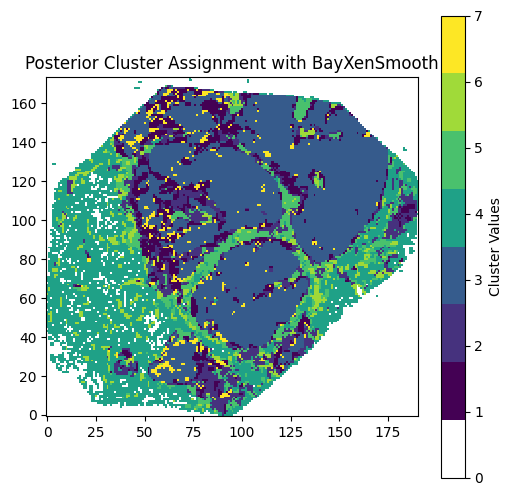

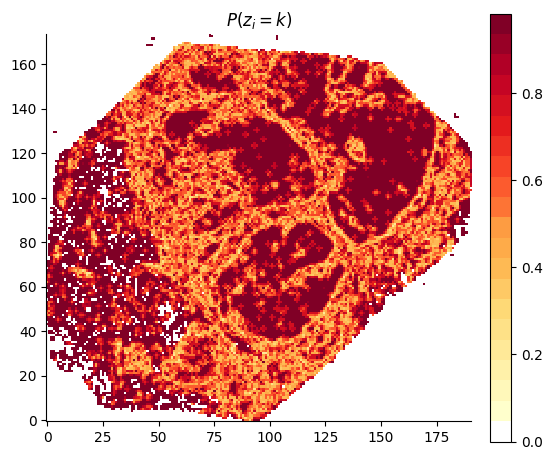

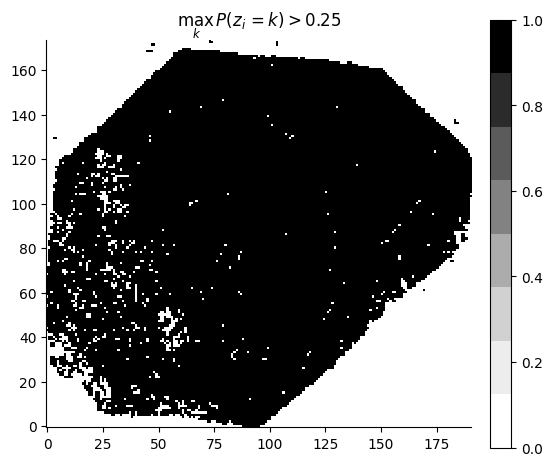

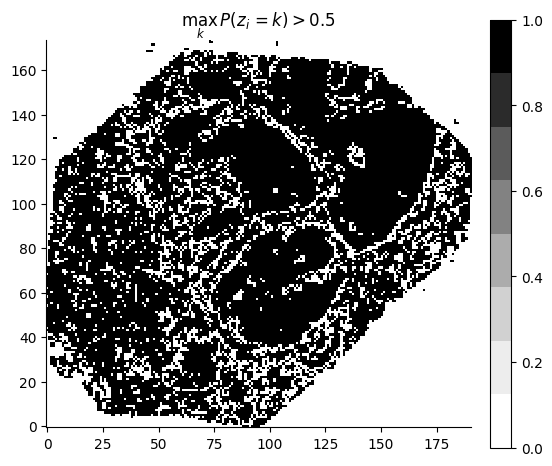

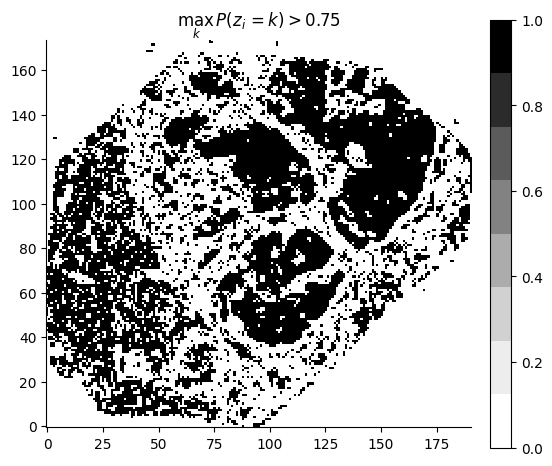

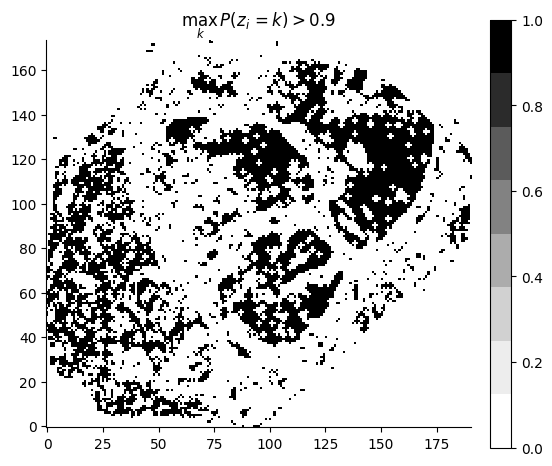

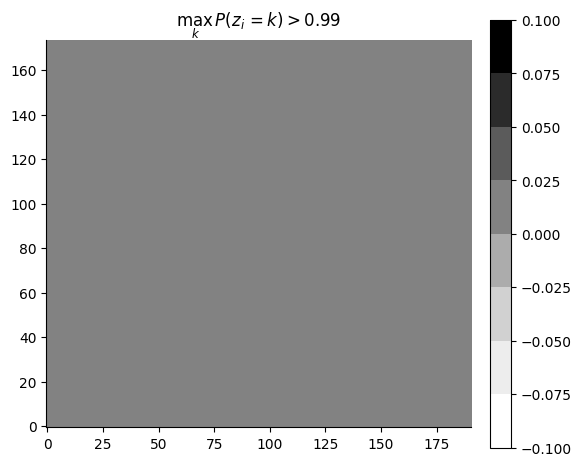

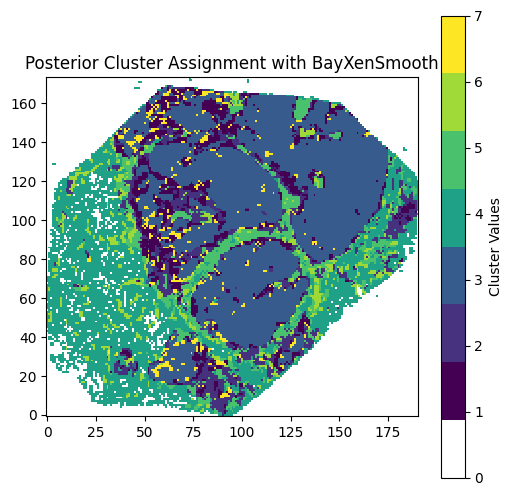

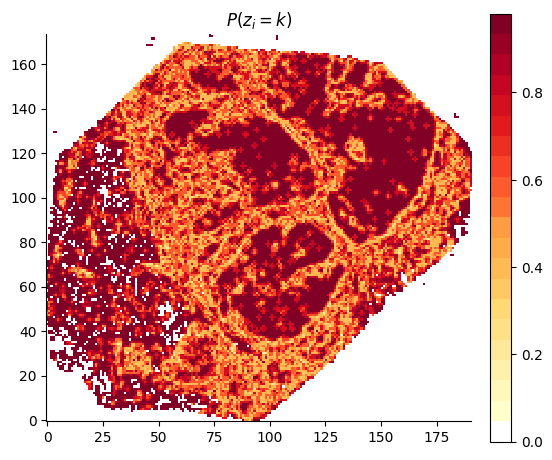

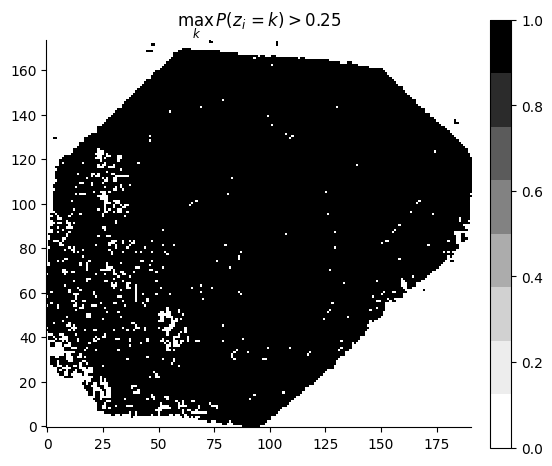

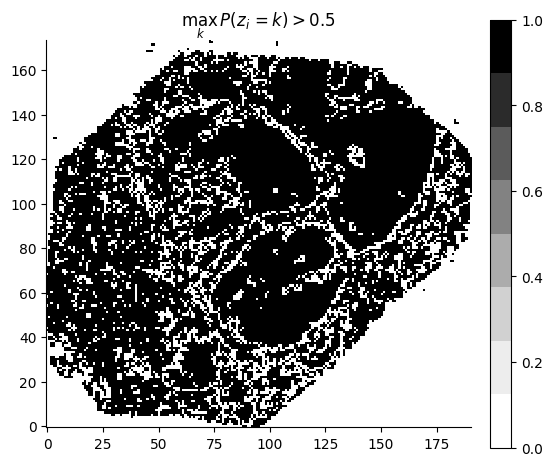

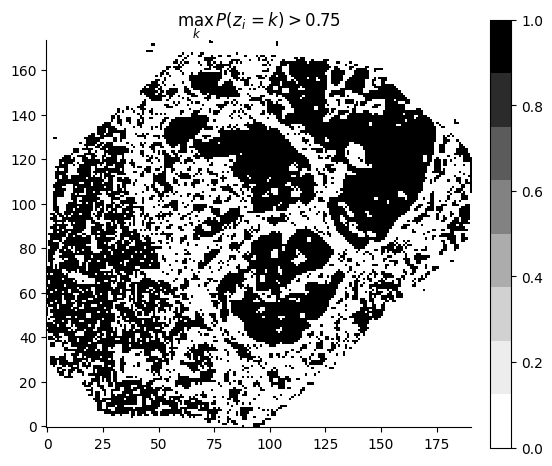

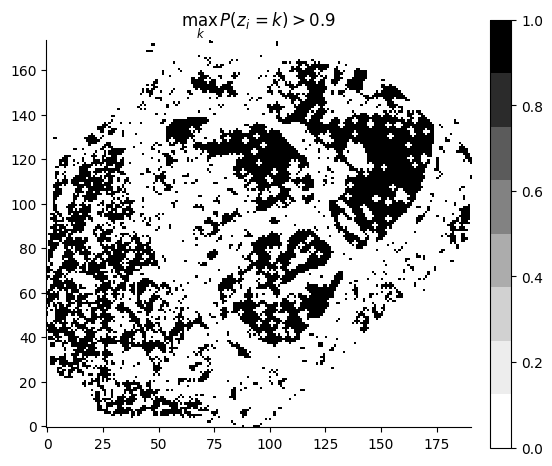

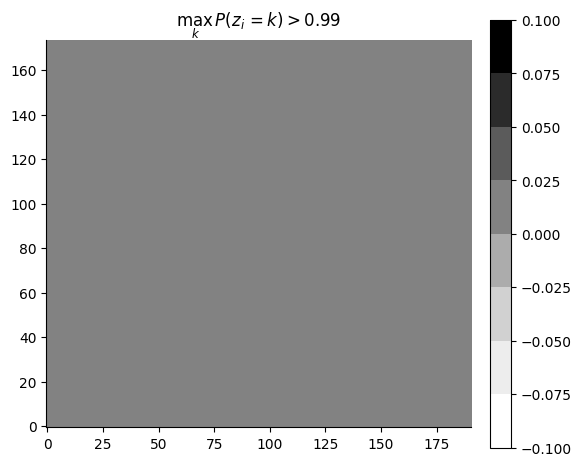

In [46]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 1000
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the mpd distance of cluster labels
        mpd = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("mpd", sum(mpd.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_mpd_filepath := save_filepath("BayXenSmooth", "mpd", sample_for_assignment)):
            os.makedirs(bayxensmooth_mpd_filepath)
        with open(f"{bayxensmooth_mpd_filepath}/mpd.json", 'w') as fp:
            json.dump(mpd, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}

    print(morans_i_markers)

   P(z_i = 1)  P(z_i = 2)  P(z_i = 3)  P(z_i = 4)  P(z_i = 5)  P(z_i = 6)  \
0    0.000915    0.987425    0.000854    0.000762    0.000917    0.000714   
1    0.000968    0.310339    0.001012    0.000981    0.000947    0.000934   
2    0.001024    0.769795    0.000848    0.000792    0.000831    0.001040   
3    0.236429    0.241208    0.000791    0.000845    0.000977    0.000801   
4    0.000971    0.522430    0.001057    0.000945    0.001080    0.000830   

   P(z_i = 7)  P(z_i = 8)  P(z_i = 9)  P(z_i = 10)  P(z_i = 11)  P(z_i = 12)  \
0    0.000762    0.000799    0.000705     0.000724     0.000764     0.000713   
1    0.000946    0.000938    0.001017     0.000966     0.000932     0.000765   
2    0.000910    0.000879    0.000938     0.000942     0.000934     0.000936   
3    0.000944    0.001066    0.000905     0.000779     0.257056     0.001006   
4    0.000847    0.000934    0.000912     0.000953     0.463405     0.000952   

   P(z_i = 13)  P(z_i = 14)  P(z_i = 15)  P(z_i = 16)  P

Text(0.5, 1.0, '$\\max_k \\,\\, P(z_i = k)$')

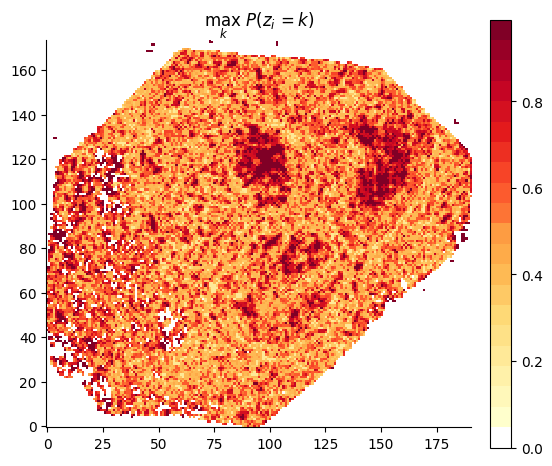

In [47]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.double).cpu()

soft_assignments = pd.read_csv(
    "results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=1.0/SIGMA_PRIOR=0.25/LOGITS_PRIOR=1.0/LEARN_GLOBAL_VARS=True/soft_clusters_K=17.csv",
    index_col=0
)
print(soft_assignments.head())
cluster_confidences = torch.tensor(soft_assignments.values.max(axis=1)).cpu()

cluster_grid[rows, columns] = cluster_confidences

heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k \,\, P(z_i = k)$')

TypeError: Invalid shape (23444,) for image data

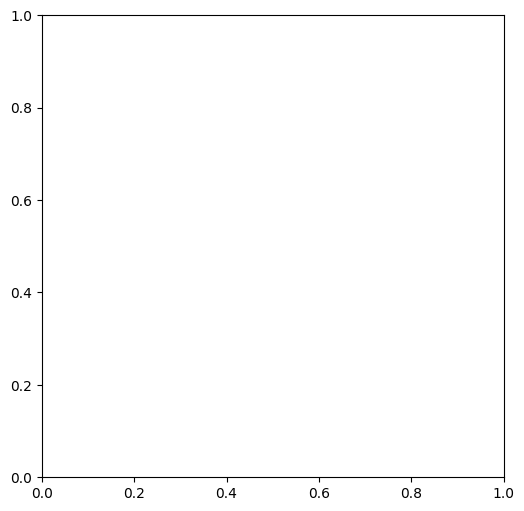

In [48]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

In [ ]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')